As part of my role at DataVine Analytics, I developed three prototype machine learning solutions to address diverse business problems using standardized datasets. Each model was tailored to reflect realistic client use cases in classification, recommendation, and clustering. My goal was to apply a consistent, efficient data science workflow—from exploratory data analysis and dimensionality reduction to model tuning and evaluation. The project revealed meaningful patterns that not only validated model performance but also provided insights into customer behavior, feed selection, and regional crime segmentation.

Project Hypothesis:
Well-structured machine learning workflows—when paired with dimensionality reduction and hyperparameter tuning—can deliver high-performing, interpretable models that improve decision-making across classification, recommendation, and clustering tasks.

Key Findings:

Wine Dataset (Classification):
Applied PCA to retain 95% variance and used GridSearchCV for hyperparameter tuning in k-NN. Achieved 97% accuracy, indicating strong feature separability and reliable wine class prediction.

Chickwts Dataset (Recommendation):
Reduced feature space using PCA and computed cosine similarity between feed types. Found high variance in nutrient composition correlating with weight, supporting personalized feed recommendations.

USArrests Dataset (Clustering):
Used PCA and clustering with both K-Means and GMM. Evaluated models with inertia, AIC, BIC, and silhouette scores. K-Means suggested 3 clusters, while GMM provided probabilistic flexibility. Visualizations revealed interpretable regional groupings based on crime patterns.

Dimensionality Reduction Across Projects
PCA helped streamline feature sets, improved model performance, and enabled clear 2D visualizations for clustering and classification interpretation.

Model Evaluation and Visualization
Used multiple evaluation metrics (accuracy, silhouette scores, AIC/BIC) to ensure robustness and justify model selection. Visual insights supported stakeholder interpretation and trust in the models.



In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

In [13]:
wine = pd.read_csv('Wine Data.csv')
chickwts = pd.read_csv('Chick Weight Data.csv')
us_arrests = pd.read_csv('Arrests Data.csv')


In [14]:
print("Wine Dataset Info:")
print(wine.info())
print(wine.describe(), "\n")

print("Chickwts Dataset Info:")
print(chickwts.info())
print(chickwts.describe(), "\n")

print("USArrests Dataset Info:")
print(us_arrests.info())
print(us_arrests.describe(), "\n")


Wine Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null   

In [15]:
# Wine Dataset
wine.dropna(inplace=True)
wine_features = wine.drop('target', axis=1)
wine_target = LabelEncoder().fit_transform(wine['target'])
wine_scaled = StandardScaler().fit_transform(wine_features)

# Chickwts Dataset
chickwts_numeric = chickwts.drop(columns=['feed_name'])
chickwts_clean = chickwts_numeric[chickwts_numeric['weight'] > 0]
chickwts_scaled = StandardScaler().fit_transform(chickwts_clean)

# USArrests Dataset
us_arrests_clean = us_arrests.drop(columns=['Unnamed: 0'])
us_arrests_scaled = StandardScaler().fit_transform(us_arrests_clean)


In [16]:
# Wine PCA
pca_wine = PCA(n_components=0.95)
wine_pca = pca_wine.fit_transform(wine_scaled)

# Chickwts PCA
pca_chick = PCA(n_components=1)
chick_pca = pca_chick.fit_transform(chickwts_scaled)

# USArrests PCA
feature_variances = np.var(us_arrests_scaled, axis=0)
top3_idx = np.argsort(feature_variances)[-3:]
us_selected = us_arrests_scaled[:, top3_idx]
us_pca = PCA(n_components=2).fit_transform(us_selected)


In [17]:
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(wine_pca, wine_target)

wine_pred = grid_search.predict(wine_pca)
print(classification_report(wine_target, wine_pred))
print("Accuracy:", accuracy_score(wine_target, wine_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       1.00      0.93      0.96        71
           2       0.94      1.00      0.97        48

    accuracy                           0.97       178
   macro avg       0.97      0.98      0.97       178
weighted avg       0.97      0.97      0.97       178

Accuracy: 0.9719101123595506


In [18]:
similarity_matrix = cosine_similarity(chick_pca)
chick_pca_df = pd.DataFrame(chick_pca, columns=['Component_1'])
chick_pca_df['feed_name'] = chickwts['feed_name'].values
ref_index = 0
chick_pca_df['similarity'] = similarity_matrix[ref_index]
chick_pca_df.sort_values(by='similarity', ascending=False)


,Component_1,feed_name,similarity
0,2.165341,FirstPeck,1.0
32,1.964308,EggMaster Premium,1.0
34,0.668990,ShellStrength Pro,1.0
36,1.089050,EggBoost Supreme,1.0
38,1.549482,PeakLay Advanced,1.0
...,...,...,...
19,-1.818182,PulletPower Premium,-1.0
64,-0.299843,FinishPro Supreme,-1.0
17,-1.559118,GrowStrong Advanced,-1.0
30,-4.676345,MatureBlend Complete,-1.0


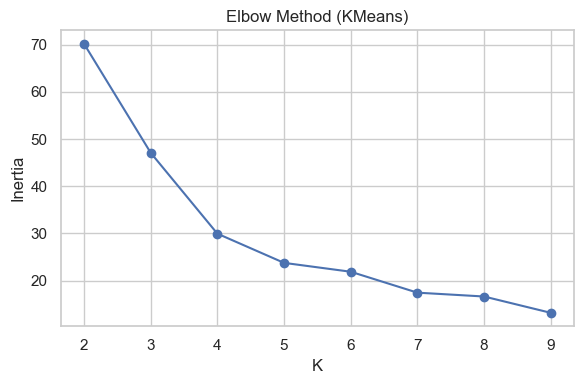

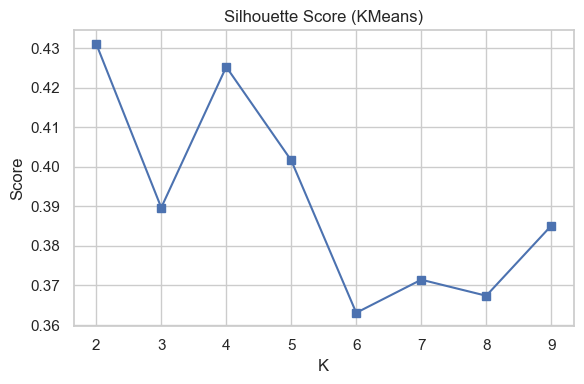

In [19]:
inertias = []
silhouette_scores_kmeans = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(us_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(us_pca, labels))

# Plot Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow Method (KMeans)')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores_kmeans, marker='s')
plt.title('Silhouette Score (KMeans)')
plt.xlabel('K')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


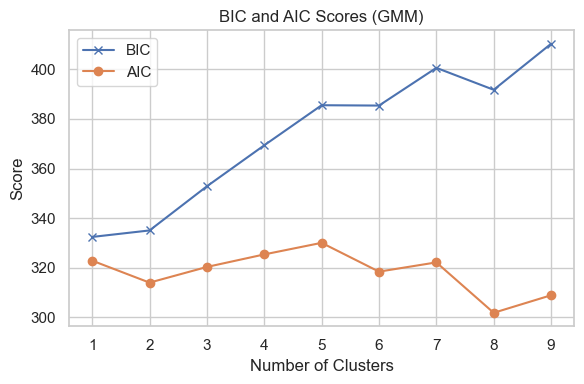

In [20]:
bic_scores = []
aic_scores = []
for k in range(1, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(us_pca)
    bic_scores.append(gmm.bic(us_pca))
    aic_scores.append(gmm.aic(us_pca))

# Plot BIC and AIC
plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), bic_scores, label='BIC', marker='x')
plt.plot(range(1, 10), aic_scores, label='AIC', marker='o')
plt.title('BIC and AIC Scores (GMM)')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()


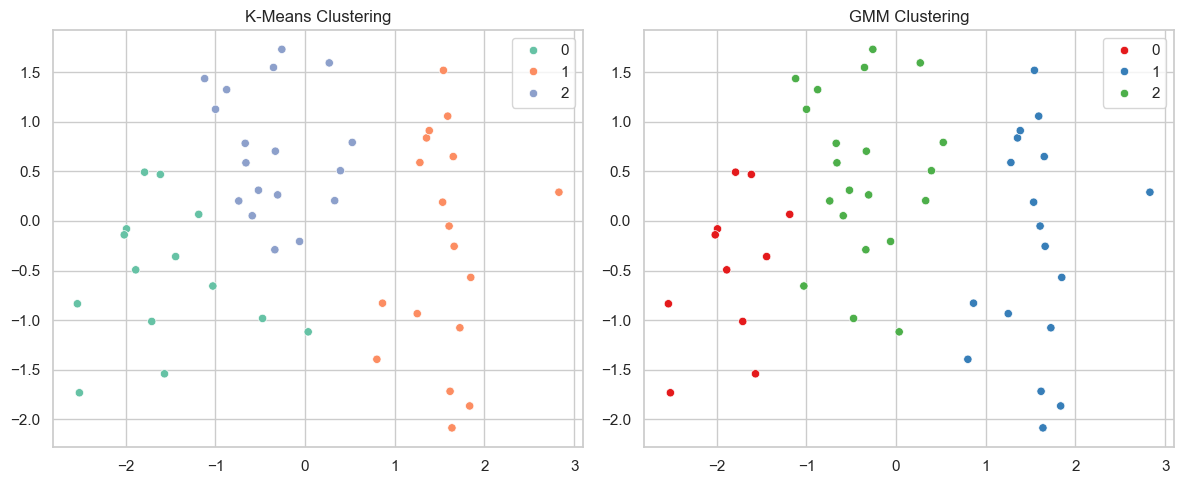

In [21]:
kmeans_final = KMeans(n_clusters=3, random_state=42).fit(us_pca)
gmm_final = GaussianMixture(n_components=3, random_state=42).fit(us_pca)
kmeans_labels = kmeans_final.predict(us_pca)
gmm_labels = gmm_final.predict(us_pca)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=us_pca[:, 0], y=us_pca[:, 1], hue=kmeans_labels, ax=axes[0], palette='Set2')
axes[0].set_title('K-Means Clustering')
sns.scatterplot(x=us_pca[:, 0], y=us_pca[:, 1], hue=gmm_labels, ax=axes[1], palette='Set1')
axes[1].set_title('GMM Clustering')
plt.tight_layout()
plt.show()
